### Reading and Cleaning data

In [29]:
import os
import pandas as pd
import numpy as np

In [30]:
# in this section we read data into a pandas DataFrame
fnames = os.listdir('Data')
frames = [pd.read_csv('Data/'+name_) for name_ in fnames]
data = pd.concat(frames,axis=0,ignore_index=True)
data.head(n=3)

,ind,catg,headline,body,imageurl,readmoreurl,inblockId
0,1,automobile,Toyota gives increased comfort & safety featur...,Toyota's Etios and Liva have 14 Standard Safet...,http://images.newsinshorts.com.edgesuite.net/a...,https://youtu.be/-_PqPwvecyE,dysqqgqf-1
1,2,automobile,Vodafone uses AR in PBL to promote new campaig...,Several pugs gatecrashed the finals of Vodafon...,http://images.newsinshorts.com.edgesuite.net/a...,https://youtu.be/yY_MRk3KEhw,dysqqgqf-1
2,3,automobile,Second-Gen Audi Q5 launched at ₹53.25 Lakh,Audi has launched the all-new Q5 with a price ...,http://images.newsinshorts.com.edgesuite.net/a...,https://youtu.be/EiJPF_aVbyo,dysqqgqf-1


In [31]:
#dropping unnecessary columns from dataframe
data = data.drop(['imageurl','headline','ind','readmoreurl','inblockId'],axis=1)
data.head()

,catg,body
0,automobile,Toyota's Etios and Liva have 14 Standard Safet...
1,automobile,Several pugs gatecrashed the finals of Vodafon...
2,automobile,Audi has launched the all-new Q5 with a price ...
3,automobile,Italian supercar maker Lamborghini on Thursday...
4,automobile,"Japanese automaker Honda is recalling 22,084 u..."


In [32]:
#remove Puncuation and numbers from our data.
import re
def remove_punctuation(s):
    return re.sub('[^A-Za-z ]','',s)
data['body'] = data['body'].apply(lambda x:remove_punctuation(x))

### Splitting data into 2 parts

In [33]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(data,test_size = 0.35,random_state=42)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [34]:
train.head()

,catg,body
0,automobile,Technology giant Apple is using the same model...
1,science,A new image from NASAs Chandra Xray Observator...
2,entertainment,The Mark Hamill late actress Carrie Fisher and...
3,automobile,Israeli startup StoreDot has created a battery...
4,world,Facebook has agreed to investigate the spread ...


### Creating CountVectorizer Model From sklearn

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words='english',ngram_range=(1,3))
train_cv = cv.fit_transform(train['body'])

In [36]:
print("Total Number of feature : ",len(cv.vocabulary_))

Total Number of feature :  330900


### Selection K best features using chi2 feature selection method

In [37]:
from sklearn.feature_selection import chi2
chi2_score = chi2(train_cv,train['catg'])
chi2_score = list(zip(cv.get_feature_names(),chi2_score[0]))

In [38]:
chi2_score[15:20]

[('aadhaar card names', 7.6340057636887622),
 ('aadhaar card pan', 7.4275668073136432),
 ('aadhaar cards', 15.268011527377524),
 ('aadhaar cards signing', 7.6340057636887622),
 ('aadhaar cards test', 7.6340057636887622)]

In [39]:
chi2_score = sorted(chi2_score,key=lambda x:x[1],reverse=True)

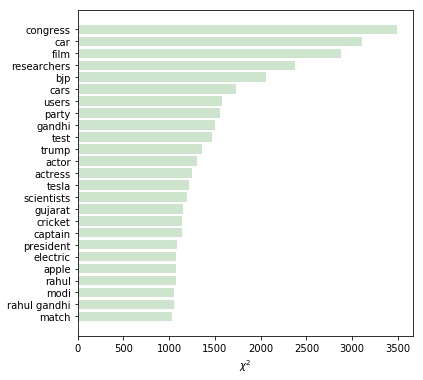

In [40]:
# plotting top features on the chart
from pylab import barh,plot,yticks,show,grid,xlabel,figure
figure(figsize=(6,6))
top_ = chi2_score[:25]
top_.reverse()
x = range(len(top_))
labels = [x[0] for x in top_]
barh(x,[x[1] for x in top_],align='center',alpha=.2,color='g')
yticks(x,labels)
xlabel('$\chi^2$')
show()

In [59]:
# selection top K feature.
K = 5000
feature_list = {chi2_score[i][0]:i for i in range(K)}

In [60]:
# creating new CountVectorizer basec on new selected features

new_cv = CountVectorizer(ngram_range=(1,3),stop_words='english',vocabulary=feature_list)
train_cv_new = new_cv.transform(train['body'])
test_cv_new = new_cv.transform(test['body'])

In [61]:
# transforming new cv to TfIdf Vector

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(train_cv_new)
train_tfidf = tfidf_transformer.transform(train_cv_new)
test_tfidf = tfidf_transformer.transform(test_cv_new)

### Training a Classifier using New CV and TF-IDF vectors

In [88]:
from sklearn.naive_bayes import MultinomialNB
nb_cv_clf = MultinomialNB(alpha=0.1)
nb_tfidf_clf = MultinomialNB(alpha=0.1)
nb_cv_clf.fit(train_cv_new,train['catg'])
nb_tfidf_clf.fit(train_tfidf,train['catg'])

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [89]:
# accuracy for naive bayes with cv
print("Test Accuracy : ",nb_cv_clf.score(test_tfidf,test['catg'])*100,"%")
print("Train Accuracy : ",nb_tfidf_clf.score(train_tfidf,train['catg'])*100,"%")

Test Accuracy :  79.795475674 %
Train Accuracy :  88.217623498 %


In [90]:
print("Test Accuracy : ",nb_tfidf_clf.score(test_tfidf,test['catg'])*100,"%")
print("Train Accuracy : ",nb_tfidf_clf.score(train_tfidf,train['catg'])*100,"%")

Test Accuracy :  80.5082119616 %
Train Accuracy :  88.217623498 %


### Analysing Results on Naive Bayes classifier

In [91]:
test_output_nb = nb_tfidf_clf.predict(test_tfidf)
train_output_nb = nb_tfidf_clf.predict(train_tfidf)

In [95]:
pd.crosstab(test['catg'],test_output_nb,rownames=['True'],colnames=['Predicted'],margins=True)

Predicted,automobile,business,entertainment,national,politics,science,sports,technology,world,All
True,,,,,,,,,,
automobile,315,8,3,3,0,1,0,13,2,345
business,16,310,1,16,8,2,0,32,12,397
entertainment,1,2,315,33,5,0,13,1,12,382
national,3,22,11,227,49,5,2,6,38,363
politics,0,2,3,38,221,0,0,1,1,266
science,3,3,0,6,0,340,1,10,3,366
sports,1,2,20,8,3,1,317,1,7,360
technology,24,33,6,8,1,17,0,269,11,369
world,5,19,2,40,0,10,3,16,284,379


### Training a SVM classifier and analysing results

In [69]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm_tfidf_clf = SVC(kernel='rbf',C=1000)
svm_tfidf_clf.fit(train_tfidf,train['catg'])

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [79]:
print("Test Accuracy : ",svm_tfidf_clf.score(test_tfidf,test['catg'])*100,"%")
print("Train Accuraccy : ",svm_tfidf_clf.score(train_tfidf,train['catg'])*100,"%")

Test Accuracy :  80.6011775643 %
Train Accuraccy :  88.5514018692 %


In [84]:
test_output_svm = svm_tfidf_clf.predict(test_tfidf)
train_output_svm = svm_tfidf_clf.predict(train_tfidf)

In [86]:
#confusion matrix for svm classifier

pd.crosstab(test['catg'],test_output_svm,rownames=['True'],colnames=['Predicted'],margins=True)

Predicted,automobile,business,entertainment,national,politics,science,sports,technology,world,All
True,,,,,,,,,,
automobile,310,10,1,5,1,2,0,13,3,345
business,15,311,1,21,6,1,0,30,12,397
entertainment,0,3,305,35,4,0,20,2,13,382
national,4,19,9,237,45,3,3,6,37,363
politics,0,3,6,35,221,0,0,0,1,266
science,1,3,1,5,0,343,1,8,4,366
sports,3,2,12,14,4,2,314,2,7,360
technology,18,34,5,10,0,17,0,276,9,369
world,3,21,1,45,0,7,1,17,284,379


### Predicting new Results from Inshorts Site

In [104]:
s = '''
CBI has booked Delhi-based diamond exporter Dwarka Das Seth International for an alleged ₹389.85-crore fraud at Oriental Bank of Commerce (OBC). Since 2007, Dwarka Das availed various credit facilities from OBC using Letters of Credit by foreign banks to pay off creditors for purchasing precious metals. This continued till OBC noticed that some of those banks were poorly rated.

'''

In [105]:
string_ = remove_punctuation(s)
cv_vec = new_cv.transform([string_])
vec__ = tfidf_transformer.transform(cv_vec)
print(nb_tfidf_clf.predict(vec__))

['business']
